In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import csv
import matplotlib.pyplot as plt
import os

import numpy as np
import pandas as pd
from PIL import Image
import seaborn as sns
from skimage.feature import hog, SIFT
from sklearn.manifold import TSNE
import tqdm
import torch
from torch import nn

In [3]:
# !export LD_LIBRARY_PATH=$LD_LIBRARY_PATH:/usr/local/cuda/extras/CUPTI/lib64

In [4]:
torch.cuda.get_device_name()

'NVIDIA GeForce RTX 3060 Laptop GPU'

In [5]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"

# Data loading

## Import

In [6]:
image_dir = "data/Images/"

In [7]:
df = pd.read_csv("data/flipkart_com-ecommerce_sample_kaggle.csv")
image_names = [os.path.splitext(image_name)[0] for image_name in os.listdir(image_dir)]

In [8]:
df = df[df["uniq_id"].isin(image_names)].reset_index(drop=True)

In [9]:
df.columns

Index(['uniq_id', 'crawl_timestamp', 'product_url', 'product_name',
       'product_category_tree', 'pid', 'retail_price', 'discounted_price',
       'image', 'is_FK_Advantage_product', 'description', 'product_rating',
       'overall_rating', 'brand', 'product_specifications'],
      dtype='object')

In [10]:
themes = []
for product in df.product_category_tree:
    themes.append(product.split('>>')[0][2:-1])
pd.Series(themes).unique()

array(['Home Furnishing', 'Baby Care', 'Watches',
       'Home Decor & Festive Needs', 'Kitchen & Dining',
       'Beauty and Personal Care', 'Computers'], dtype=object)

In [21]:
def load_images(image_names):
    images = []
    for image_name in tqdm.tqdm(image_names):
        image = Image.open(os.path.join(image_dir, image_name + ".jpg")).resize((100, 100))
        image = image.convert("L")
        images.append(np.array(image))
    return images

images = load_images(image_names)

100%|██████████| 1050/1050 [00:22<00:00, 47.15it/s]


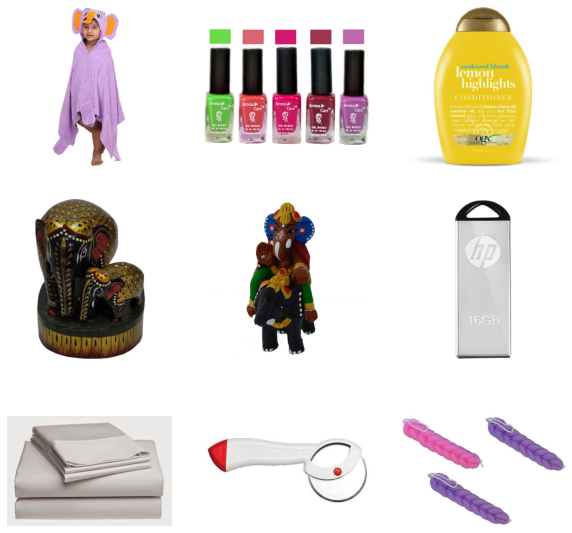

In [14]:
def plot_data(image_names):
    plt.figure(figsize=(10, 10))
    for i in range(9):
        plt.subplot(3, 3, i+1)
        image_name = str(np.random.choice(image_names)) + ".jpg"
        image = Image.open(os.path.join(image_dir, image_name))
        plt.imshow(image)
        plt.axis("off")

plot_data(image_names)

## Size analysis

In [15]:
def get_sizes(image_names):
    heights = []
    widths = []
    ratios = []
    for image_name in image_names:
        image = Image.open(os.path.join(image_dir, image_name + ".jpg"))
        heights.append(image.size[0])
        widths.append(image.size[1])
        ratios.append(image.size[0] / image.size[1])
    
    return heights, widths, ratios

heights, widths, ratios = get_sizes(image_names)

<AxesSubplot:ylabel='Count'>

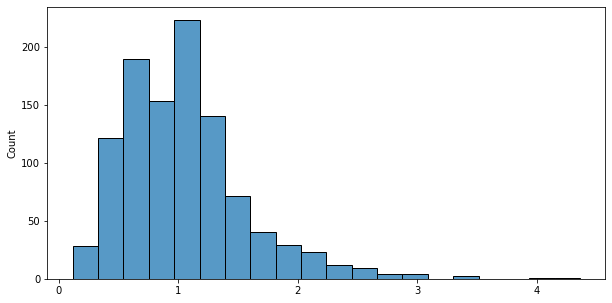

In [16]:
plt.figure(figsize = (10,5))
sns.histplot(ratios, bins = 20)

<AxesSubplot:ylabel='Count'>

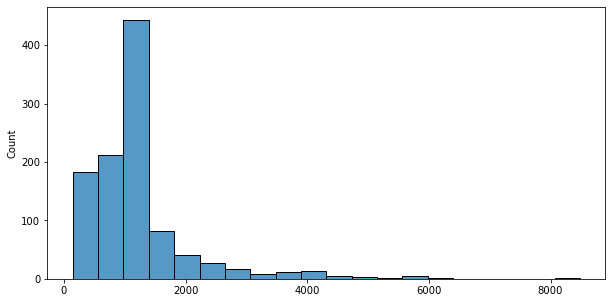

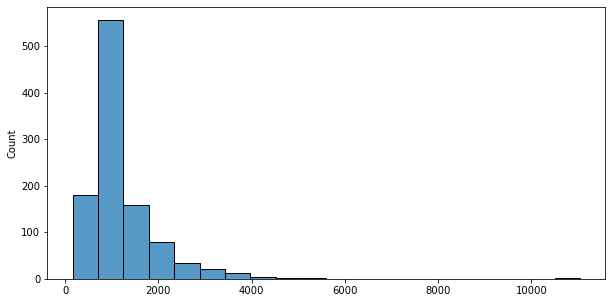

In [17]:
plt.figure(figsize = (10,5))
sns.histplot(heights, bins = 20)
plt.figure(figsize=(10, 5))
sns.histplot(widths, bins =20)

# Processing (resize, normalize, HOG)

## Normalization (Min Max)

In [19]:
def min_max_norm(image: np.array):
    min = image.min()
    max = image.max()

    return (image - min) / (max - min)

## HOG Feature Extraction

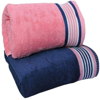

In [22]:
image_path = np.random.choice(image_names)
image = Image.open(os.path.join(image_dir, image_path + ".jpg")).resize((100, 100))
image

In [23]:
def get_hog(image: np.array):
    _, hog_image = hog(image, orientations = 9, pixels_per_cell=(8, 8), cells_per_block=(2, 2), visualize=True, multichannel=True)
    return np.expand_dims(hog_image, axis=2)

(-0.5, 99.5, 99.5, -0.5)

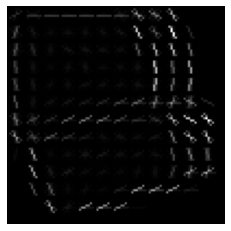

In [24]:
hog_image = get_hog(np.array(image))

plt.imshow(hog_image, cmap="gray")
plt.axis("off")

## SIFT Feature Extraction

In [25]:
def get_sift(image: np.array):
    image = np.array(Image.fromarray(image).convert("L"))
    sift = SIFT()
    try:
        sift.detect_and_extract(image)
    except:
        sift.detect_and_extract(image * 5)
    desc_image = np.array(Image.fromarray(sift.descriptors).resize((100, 100)))
    return np.expand_dims(desc_image, axis=2)

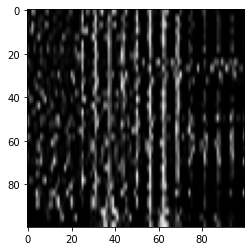

In [26]:
desc_image = get_sift(np.array(image))

plt.imshow(desc_image, cmap="gray")

## Encoding feature extraction (NN)

In [28]:
X = torch.Tensor(images).to(device)

In [205]:
class AutoEncoder(nn.Module):
    def __init__(self):
        super(AutoEncoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Flatten(0),
            nn.Linear(10000, 2000),
            nn.ReLU(),            
            nn.Linear(2000, 500),
            nn.ReLU(),
            nn.Linear(500, 50),
            nn.ReLU(),
        )
        self.decoder = nn.Sequential(
            nn.Linear(50, 500),
            nn.ReLU(),
            nn.Linear(500, 2000),
            nn.ReLU(),
            nn.Linear(2000, 10000),
            nn.ReLU(),
            nn.Unflatten(0, torch.Size([100, 100])),
        )
    
    def forward(self, x):
        print(x.size())
        if x.size() == torch.Size([100, 100]):
            
            x = self.encoder(x)
            x = self.decoder(x)
        else:
            x_final = []
            for xi in tqdm.tqdm(x):
                xi = self.encoder(xi)
                xi = self.decoder(xi).cpu()
                x_final.append(xi.detach().numpy())
            x = torch.from_numpy(np.array(x_final))
        return x


In [206]:
model = AutoEncoder().to(device)

In [207]:
def get_n_params(model):
    pp=0
    for p in list(model.parameters()):
        nn=1
        for s in list(p.size()):
            nn = nn*s
        pp += nn
    return pp

get_n_params(model)

42065050

In [210]:
lr = 0.001
epochs = 50

loss_fn = nn.MSELoss(reduction="mean")
optimizer = torch.optim.SGD(model.parameters(), lr = lr)

losses = []
for epoch in range(epochs):
    model.train().to(device)

    y_pred = model.forward(X)
    print(y_pred.size())
    print(X.size())
    loss = loss_fn(X, y_pred).cpu()
    loss.backward()

    optimizer.step()
    optimizer.zero_grad()
    print("loss : ", loss)
    losses.append(loss.item())


torch.Size([1050, 100, 100])


100%|██████████| 1050/1050 [00:00<00:00, 1139.63it/s]

torch.Size([1050, 100, 100])
torch.Size([1050, 100, 100])


RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cuda:0 and cpu!

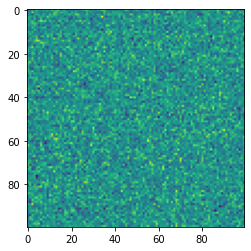

In [ ]:
input = np.expand_dims(np.array(Image.fromarray(images[0]).convert("L")), axis=2)
input = torch.Tensor(images[0])
model = AutoEncoder()

output = model(input)
array = output.view(100, 100, 1).detach().numpy()
plt.imshow(array)

## Main

In [ ]:
def process_images(image_names, size = (100, 100)):
    images = []
    for image_id in tqdm.tqdm(image_names):
        image_path = os.path.join(image_dir, image_id + ".jpg")
        image = Image.open(image_path).resize(size)
        img = np.array(image)

        # Apply HOG feature extraction method
        hog_image = get_hog(img)

        # Apply SIFT feature extraction method
        desc_image = get_sift(img)

        built_image = np.concatenate((hog_image, desc_image), axis = 2)
        built_image = min_max_norm(np.array(built_image))
        images.append(built_image.flatten())
    
    return images
        

# t-SNE dimension reduction

In [ ]:
def get_tsne(X, y, n_components = 2, plot = False):
    tsne = TSNE(n_components)
    tsne_res = tsne.fit_transform(X)
    plt.figure(figsize=(10,10))
    if plot:
        sns.scatterplot(x = tsne_res[:, 0], y = tsne_res[:, 1], hue = y)
    else:
        return tsne_res

In [ ]:
y = [product.split(">>")[0][2:-1] for product in df.product_category_tree]

## Color images

100%|██████████| 1050/1050 [01:10<00:00, 14.80it/s]


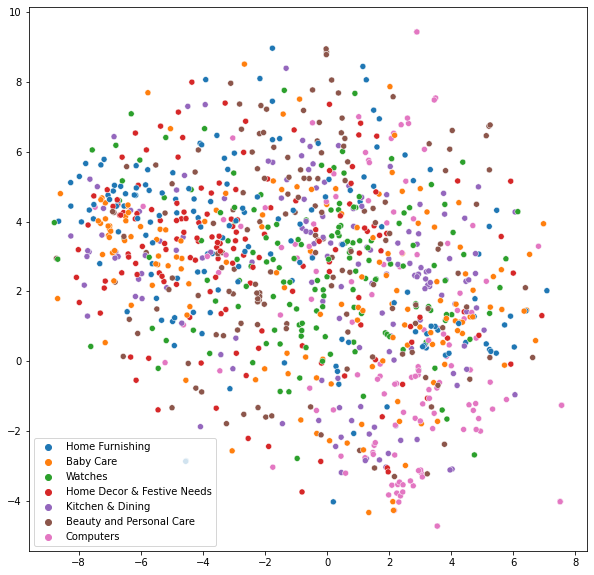

In [ ]:
X_color = process_images(df.uniq_id, (100, 100))
get_tsne(X_color, y, n_components = 2, plot = True)

# NLP